### 1: Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN


import math
import sys
print(sys.executable)


b:\Dublin City University\Practicum\Proj\venv_311\Scripts\python.exe


### 2: Load and Explore Dataset

In [2]:
multimodal = pd.read_csv("B:/Dublin City University/Practicum/Proj/Dataset/main/processed/multimodal_dataset_final_v4_1.csv", parse_dates=["Date"])
multimodal.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Log_Returns,Volatility_Log_10,cl-op,...,total_question_intent,total_action_intent,sentiment_minus_uncertainty,sentiment_minus_fear,sentiment_minus_action,sentiment_minus_urgency,sentiment_minus_prediction,Next_3_Close,Next_7_Close,Next_Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,NaN,NaN,25.128907,...,0.363636,0.500,0.025843,-0.974157,-0.974157,0.025843,-0.307490,17409.720703,17780.830078,17929.990234
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,-0.001080,NaN,217.230468,...,0.363636,0.250,-0.238229,-0.238229,-0.071562,0.428438,-0.238229,17140.240234,17829.730469,17694.679688
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,-0.013211,NaN,238.660157,...,0.454545,0.375,0.197063,-0.136270,-0.552937,-0.302937,0.197063,17400.750000,17804.869141,17409.720703
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,-0.016235,NaN,219.210937,...,0.545455,0.375,-0.642541,0.024126,-0.725874,-0.475874,-0.642541,18011.070312,17675.160156,17140.240234
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-0.015600,NaN,-214.970704,...,0.181818,0.375,-0.571208,-0.237874,-0.654541,-0.404541,-0.571208,17780.830078,17733.099609,17400.750000


In [3]:
missing_values = multimodal.isnull().sum()
print("\nMissing values per column:")
missing_values[missing_values > 0]


Missing values per column:


Log_Returns           1
Volatility_Log_10    10
pct_change            1
Next_3_Close          3
Next_7_Close          7
Next_Close            1
dtype: int64

In [4]:
multimodal.describe()
multimodal.dtypes

Date                           datetime64[ns]
Open                                  float64
High                                  float64
Low                                   float64
Close                                 float64
Volume                                  int64
Adj Close                             float64
Log_Returns                           float64
Volatility_Log_10                     float64
cl-op                                 float64
hi-lo                                 float64
Label                                   int64
vader_news_sentiment                  float64
FinBERT_news_sentiment                float64
Smart_news_sentiment                  float64
news_buying_intent                    float64
news_selling_intent                   float64
news_uncertainty_intent               float64
news_urgency_intent                   float64
news_prediction_intent                float64
news_fear_intent                      float64
news_greed_intent                 

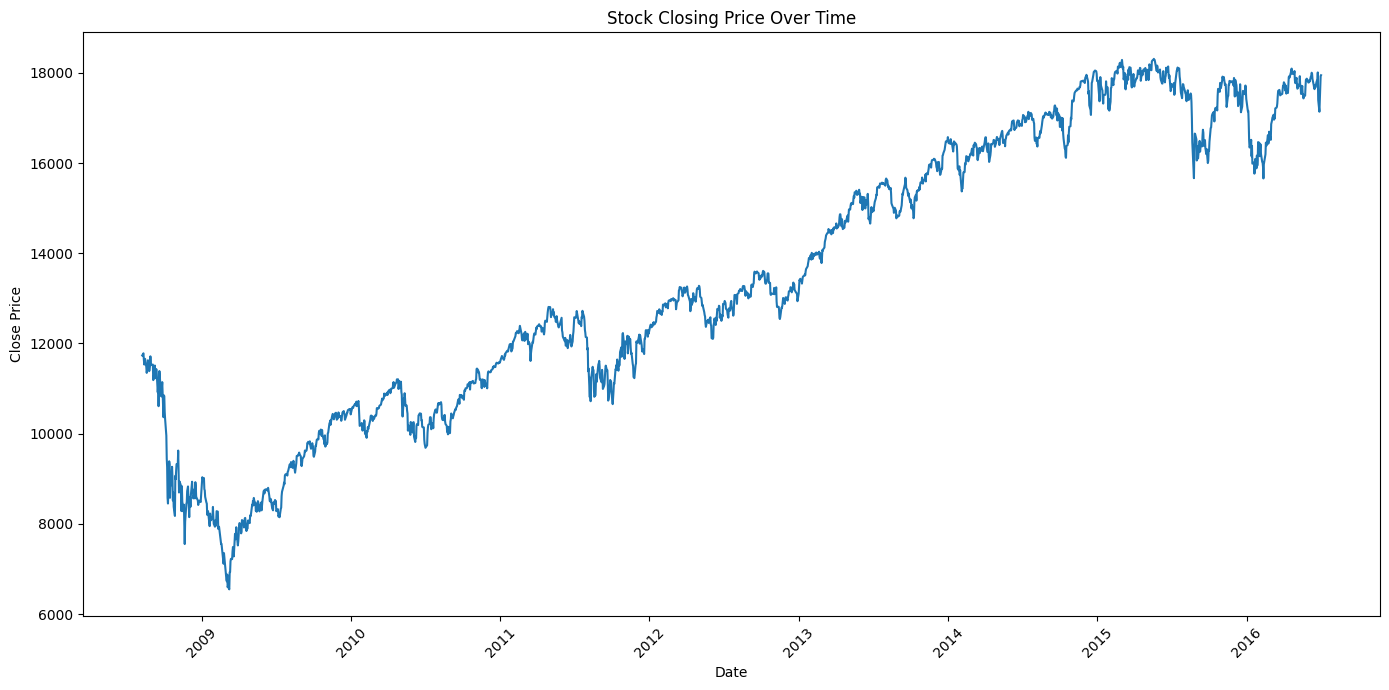

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(multimodal['Date']), multimodal['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3: Data Preprocessing

In [6]:
# Drop top 10 (rolling NaNs) and bottom 7 (from shift(-7))
multimodal_modelling = multimodal.iloc[10:-7].copy()

# Optional: reset index
# multimodal_modelling.reset_index(drop=True, inplace=True)

# Sanity check
print(f"Shape: {multimodal_modelling.shape}")
print(multimodal_modelling.isnull().sum())

Shape: (1972, 56)
Date                           0
Open                           0
High                           0
Low                            0
Close                          0
Volume                         0
Adj Close                      0
Log_Returns                    0
Volatility_Log_10              0
cl-op                          0
hi-lo                          0
Label                          0
vader_news_sentiment           0
FinBERT_news_sentiment         0
Smart_news_sentiment           0
news_buying_intent             0
news_selling_intent            0
news_uncertainty_intent        0
news_urgency_intent            0
news_prediction_intent         0
news_fear_intent               0
news_greed_intent              0
news_question_intent           0
news_action_intent             0
vader_reddit_sentiment         0
FinBERT_reddit_sentiment       0
Smart_reddit_sentiment         0
reddit_buying_intent           0
reddit_selling_intent          0
reddit_uncertainty_intent

In [7]:
df_targets = multimodal_modelling[["Date", "Target", "Label", "Next_Close", "Next_3_Close", "Next_7_Close"]].copy()

df_arima = multimodal_modelling[["Date", "Close"]].copy()
df_arima.set_index("Date", inplace=True)

drop_cols_lstm = ["Date", "Label", "Target", "Next_Close", "Next_3_Close", "Next_7_Close"]
df_lstm = multimodal_modelling.drop(columns=drop_cols_lstm).copy()

drop_cols_tcn = ["Date", "Label", "Target", "Next_Close", "Next_3_Close", "Next_7_Close"]
df_tcn = multimodal_modelling.drop(columns=drop_cols_tcn).copy()

### 4: Time Series Stationarity Analysis for ARIMA

In [8]:
df_arima.head()

,Close
Date,
2016-06-17,17675.160156
2016-06-16,17733.099609
2016-06-15,17640.169922
2016-06-14,17674.820312
2016-06-13,17732.480469


In [9]:
result = adfuller(df_arima["Close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.210171226984291
p-value: 0.6692050737972017


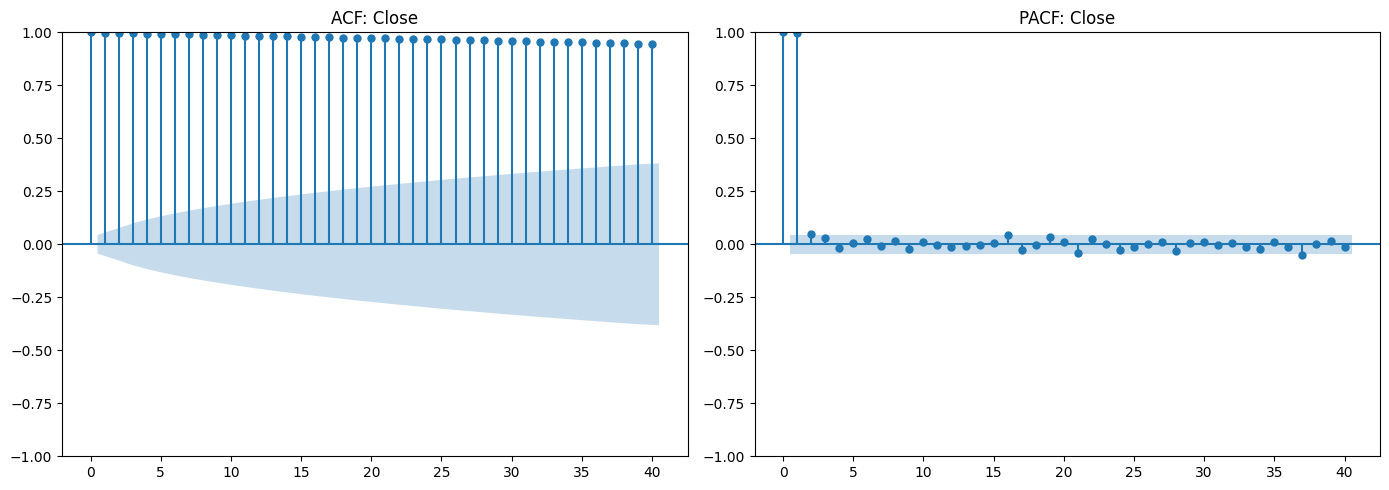

In [10]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(multimodal_modelling["Close"], lags=40, ax=plt.gca())
plt.title("ACF: Close")

plt.subplot(1, 2, 2)
plot_pacf(multimodal_modelling["Close"], lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF: Close")

plt.tight_layout()
plt.show()

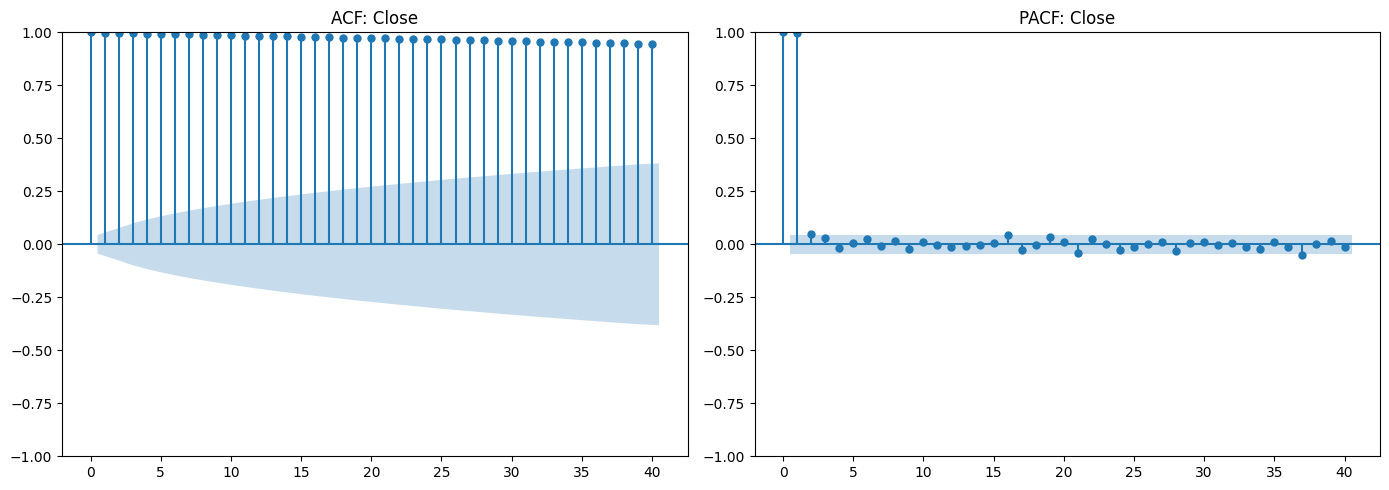

In [11]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(df_arima["Close"], lags=40, ax=plt.gca())
plt.title("ACF: Close")

plt.subplot(1, 2, 2)
plot_pacf(df_arima["Close"], lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF: Close")

plt.tight_layout()
plt.show()


Training ARIMA model for target: Next_Close
Next_Close — R²: 0.9937, MSE: 61862.34


b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will 

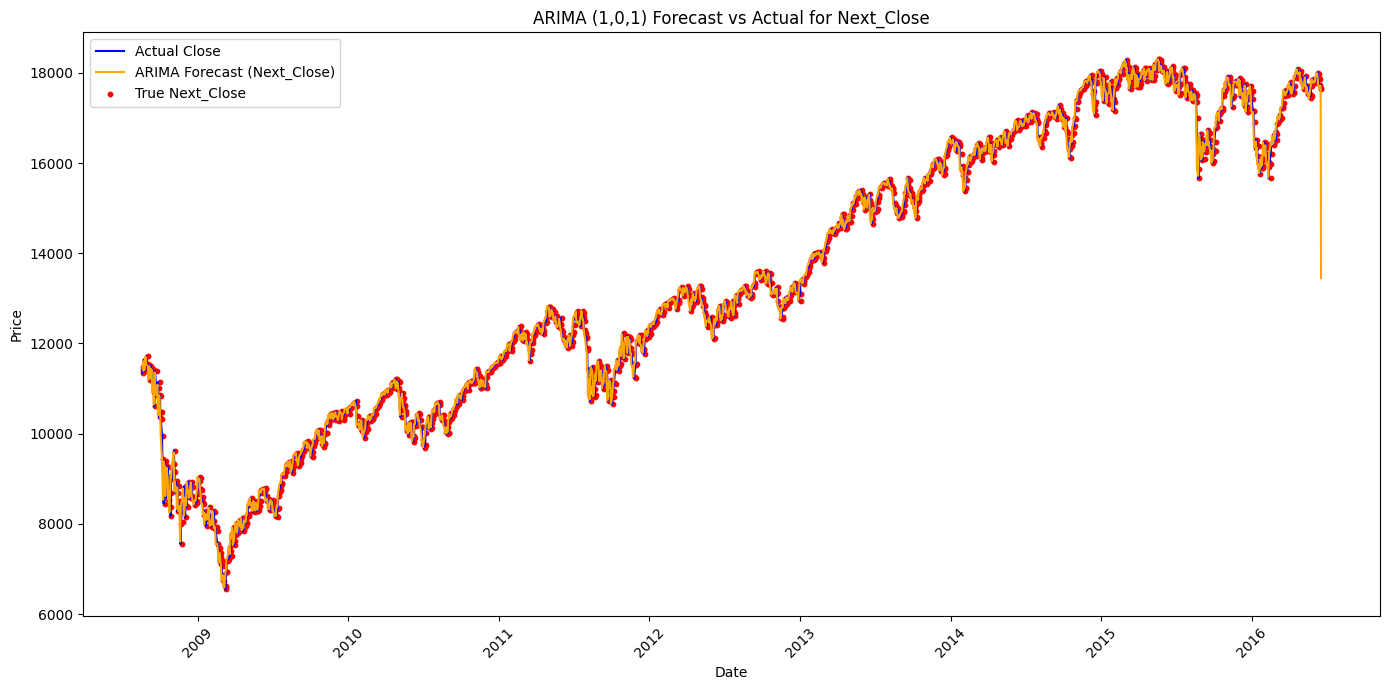

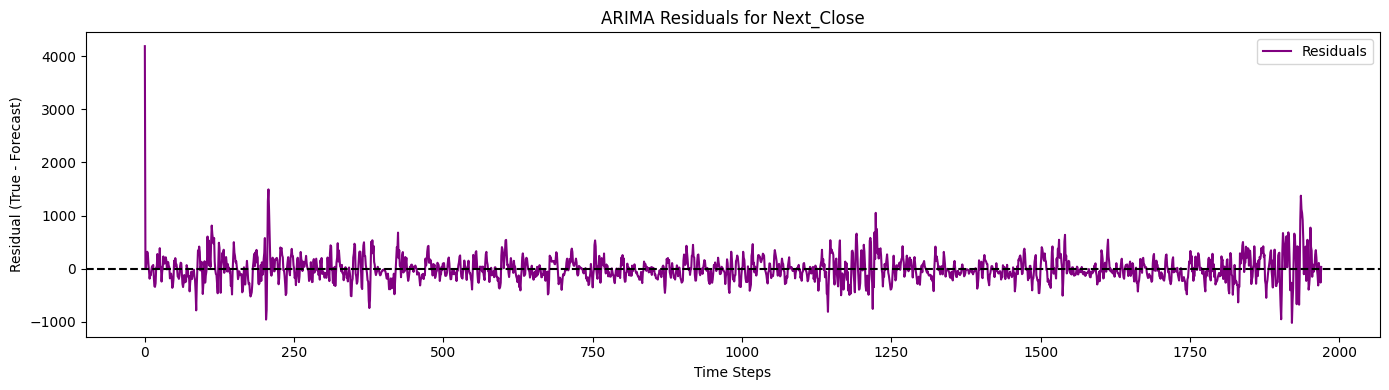


Training ARIMA model for target: Next_3_Close
Next_3_Close — R²: 0.9873, MSE: 124550.09


b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will 

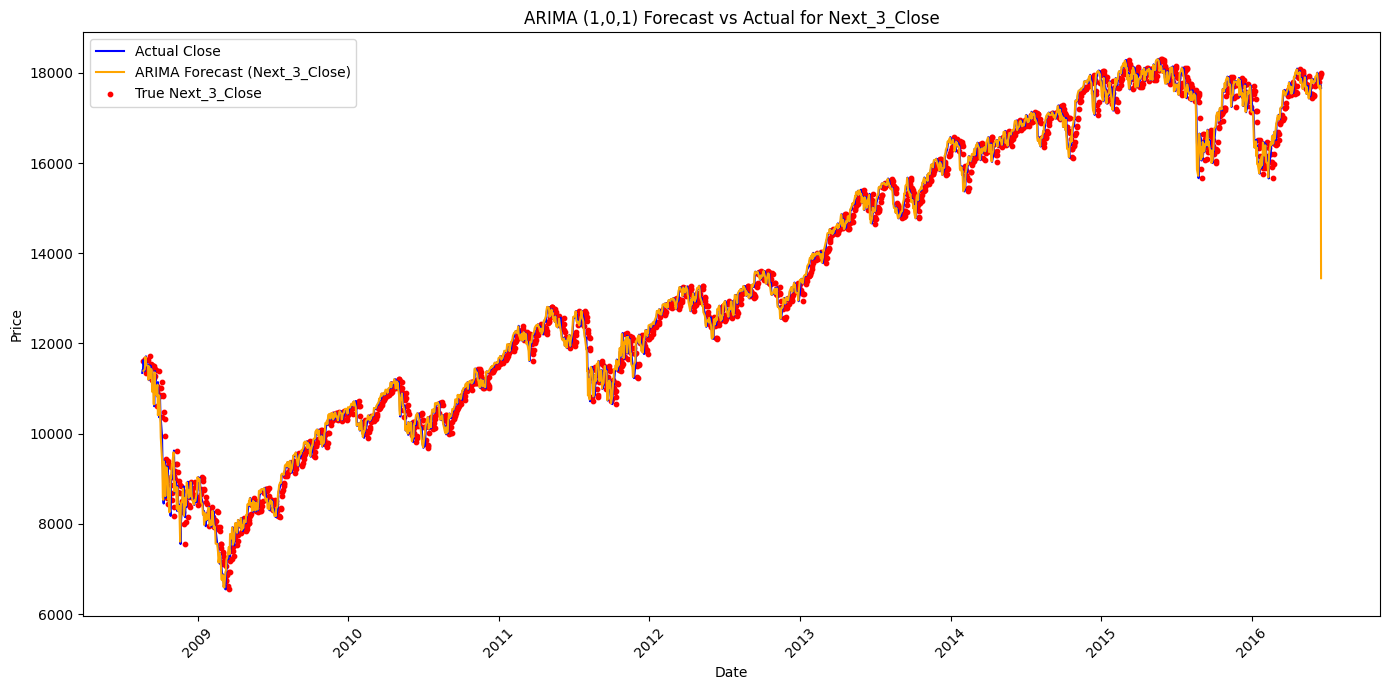

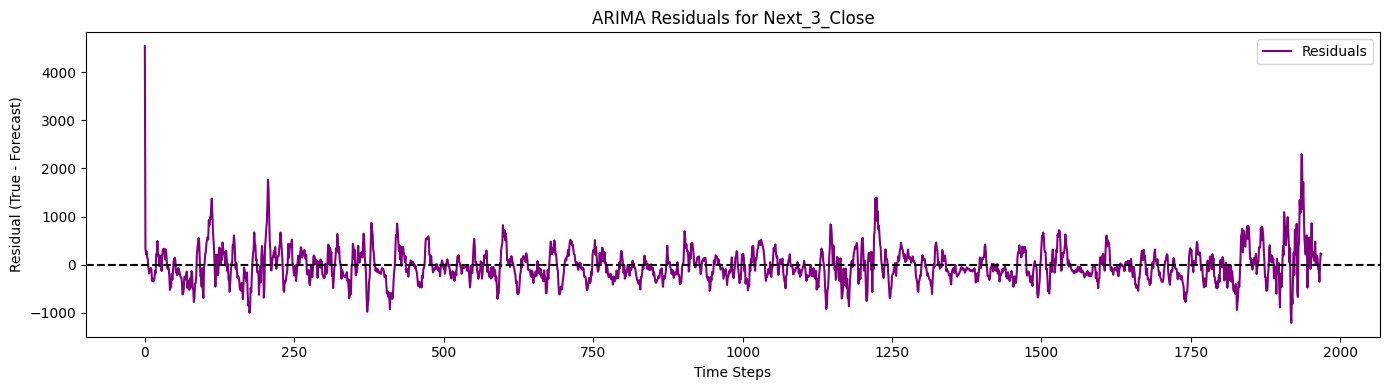


Training ARIMA model for target: Next_7_Close
Next_7_Close — R²: 0.9750, MSE: 244703.86


b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
b:\Dublin City University\Practicum\Proj\venv_311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will 

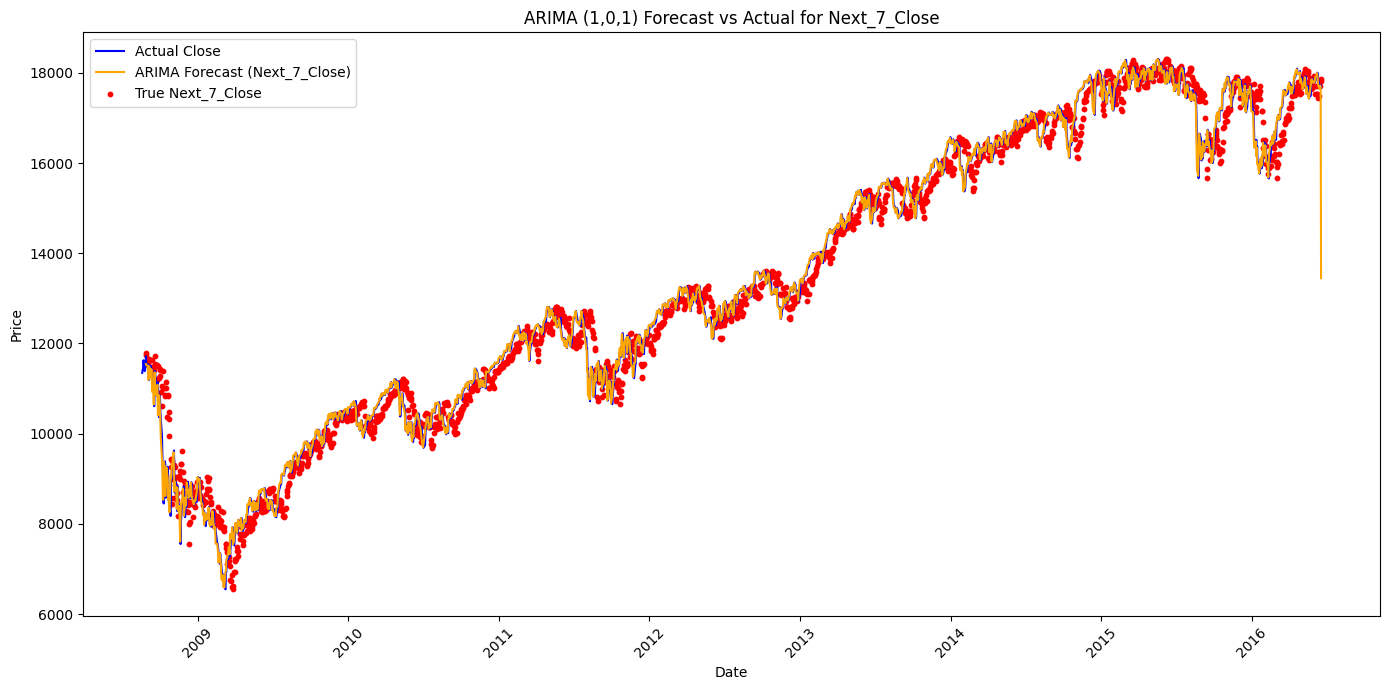

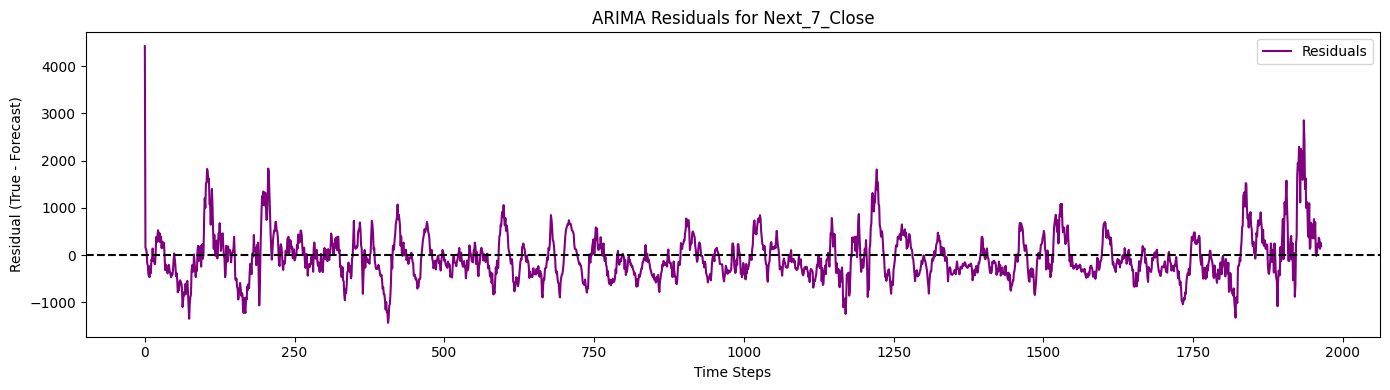

In [ ]:
def train_arima(df_arima, df_targets, target_col='Next_Close', order=(1, 0, 1)):
    print(f"\nTraining ARIMA model for target: {target_col}")

    if target_col == 'Next_Close':
        shift_n = 1
    elif 'Next_' in target_col and '_Close' in target_col:
        shift_n = int(target_col.replace('Next_', '').replace('_Close', ''))
    else:
        shift_n = 1


    model = ARIMA(df_arima["Close"], order=order)
    model_fit = model.fit()

    forecast = model_fit.predict(start=0, end=len(df_arima) - 1)

    # Shift forecast to align with future target (Next_N_Close)
    forecast = forecast.shift(shift_n)
    forecast = forecast[:len(df_targets)]

    true = df_targets[target_col]

    min_len = min(len(forecast), len(true))
    forecast = forecast[:min_len]
    true = true[:min_len]

    mask = forecast.notna()
    forecast_clean = forecast[mask].values
    true_clean = true.values[mask.values]

    r2 = r2_score(true_clean, forecast_clean)
    mse = mean_squared_error(true_clean, forecast_clean)
    print(f"{target_col} — R²: {r2:.4f}, MSE: {mse:.2f}")

    return model_fit, forecast_clean, true_clean


def plot_arima_results(df_arima, forecast, true, target_col='Next_Close'):
    plt.figure(figsize=(14, 7))
    plt.plot(df_arima.index, df_arima["Close"], label='Actual Close', color='blue')
    plt.plot(df_arima.index[:len(forecast)], forecast, label=f'ARIMA Forecast ({target_col})', color='orange')
    plt.scatter(df_arima.index[:len(true)], true, label=f'True {target_col}', color='red', s=10)
    plt.title(f'ARIMA (1,0,1) Forecast vs Actual for {target_col}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for target in ['Next_Close', 'Next_3_Close', 'Next_7_Close']:
    model, forecast, true = train_arima(df_arima, df_targets, target_col=target)
    plot_arima_results(df_arima, forecast, true, target_col=target)

    # Plot residuals
    residuals = true - forecast
    plt.figure(figsize=(14, 4))
    plt.plot(residuals, label="Residuals", color='purple')
    plt.axhline(0, linestyle='--', color='black')
    plt.title(f'ARIMA Residuals for {target}')
    plt.xlabel('Time Steps')
    plt.ylabel('Residual (True - Forecast)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## LSTM Model

In [20]:
df_lstm.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Log_Returns',
       'Volatility_Log_10', 'cl-op', 'hi-lo', 'vader_news_sentiment',
       'FinBERT_news_sentiment', 'Smart_news_sentiment', 'news_buying_intent',
       'news_selling_intent', 'news_uncertainty_intent', 'news_urgency_intent',
       'news_prediction_intent', 'news_fear_intent', 'news_greed_intent',
       'news_question_intent', 'news_action_intent', 'vader_reddit_sentiment',
       'FinBERT_reddit_sentiment', 'Smart_reddit_sentiment',
       'reddit_buying_intent', 'reddit_selling_intent',
       'reddit_uncertainty_intent', 'reddit_urgency_intent',
       'reddit_prediction_intent', 'reddit_fear_intent', 'reddit_greed_intent',
       'reddit_question_intent', 'reddit_action_intent', 'pct_change',
       'finbert_final_sentiment', 'total_buying_intent',
       'total_selling_intent', 'total_uncertainty_intent',
       'total_urgency_intent', 'total_prediction_intent', 'total_fear_intent',
       'total_gre

In [ ]:
# Separate features and target
X = df_lstm
y = df_targets[['Next_Close', 'Next_3_Close', 'Next_7_Close']].values

# Scale features and target
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Create sequences
def create_sequences(X, y, window_size=60):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Return final sequence shapes
X_seq.shape, y_seq.shape

In [ ]:
# simple lstm model
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

y_pred_scaled = model.predict(X_test)

y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

y_pred[:5], y_true[:5]

rmse_s = np.sqrt(mean_squared_error(y_true, y_pred))
r2_s = r2_score(y_true, y_pred)

print(f"RMSE: {rmse_s:.2f}")
print(f"R²: {r2_s:.4f}")

# Evaluate individual targets
target_names = ['Next_Close', 'Next_3_Close', 'Next_7_Close']

for i, name in enumerate(target_names):
    rmse_is = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2_is = r2_score(y_true[:, i], y_pred[:, i])
    print(f"{name} — RMSE: {rmse_is:.2f}, R²: {r2_is:.4f}")


In [ ]:
def plot_predictions(y_true, y_pred, title='Model Predictions vs Actuals'):
    target_names = ['Next_Close', 'Next_3_Close', 'Next_7_Close']
    plt.figure(figsize=(18, 4))

    for i, name in enumerate(target_names):
        plt.subplot(1, 3, i+1)
        plt.plot(y_true[:, i], label='Actual')
        plt.plot(y_pred[:, i], label='Predicted')
        plt.title(f'{title} — {name}')
        plt.xlabel('Sample')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()

    plt.show()

# For Single-Layer LSTM
plot_predictions(y_true, y_pred, title='Single LSTM')

In [ ]:
# two Stacked layers LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

y_pred_scaled = model.predict(X_test)

y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Evaluate individual targets
target_names = ['Next_Close', 'Next_3_Close', 'Next_7_Close']

for i, name in enumerate(target_names):
    rmse_i = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2_i = r2_score(y_true[:, i], y_pred[:, i])
    print(f"{name} — RMSE: {rmse_i:.2f}, R²: {r2_i:.4f}")


In [ ]:
# For Stacked LSTM
plot_predictions(y_true, y_pred, title='Stacked LSTM')

## Temporal Convolutional Networks

In [ ]:
X = df_tcn.values
y = df_targets[['Next_Close', 'Next_3_Close', 'Next_7_Close']].values

# Scale features and target
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [ ]:
def create_sequences(X, y, window_size=60):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)
print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

In [ ]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [ ]:
model = Sequential([
    TCN(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8],
        return_sequences=False,
        activation='relu',
        dropout_rate=0.2
    ),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3)  # Output layer for Next_Close, Next_3_Close, Next_7_Close
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

mse_t = mean_squared_error(y_true, y_pred)
r2_t = r2_score(y_true, y_pred)

print(f"✅ MSE: {mse_t:.4f}")
print(f"✅ R²: {r2_t:.4f}")

# Evaluate individual targets
target_names = ['Next_Close', 'Next_3_Close', 'Next_7_Close']

for i, name in enumerate(target_names):
    rmse_it = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2_it = r2_score(y_true[:, i], y_pred[:, i])
    print(f"{name} — RMSE: {rmse_it:.2f}, R²: {r2_it:.4f}")

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='tcn_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='TCN Prediction')
plt.title("TCN: Actual vs Predicted Next_Close")
plt.legend()
plt.show()

# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(14,4))
plt.plot(residuals)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals")
plt.show()
